
# Logistic-Map Symbol Dynamics (No Transient Discard) with explicit A-band `[τ_L, τ_U]`

This notebook **does not discard transients**. We start from the very first value (including \(x_0\)) and symbolization begins **at \(t=0\)**.  
We keep the explicit A-band \([\,\tau_L,\tau_U\,]\) (inclusive).

- If \(x \in [\tau_L,\tau_U]\) → **A**
- If \(x > \tau_U\) → **B**
- If \(x < \tau_L\) → **D**

We then compute the symbol sequence, transition counts/matrix, stationary distribution, spectral gap, entropy rate, and plot time-series, return map, and symbol network.



## 0. Configuration

- Set `tauL` and `tauU` so that values in `[tauL, tauU]` are labeled `A` (inclusive).
- Logistic map: parameter `r` and initial condition `x0`.
- We generate exactly `n_steps` values **including** the initial point \(x_0\).


In [1]:

# --- Configuration: explicit A-band [tauL, tauU] ---
tauL = 0.48   # lower bound of A band (inclusive)
tauU = 0.52   # upper bound of A band (inclusive)

# Sanity: ensure tauL <= tauU and both within (0,1)
assert 0.0 < tauL <= tauU < 1.0, "Require 0 < tauL <= tauU < 1"

# --- Logistic map parameters ---
r = 3.55       # logistic parameter; try 3.5, 3.7, 3.9, 4.0 etc.
x0 = 0.51  # initial condition in (0, 1)

# --- Number of steps (NO transient discard) ---
# We will return an array of length n_steps + 1 that INCLUDES x0.
n_steps = 700



## 1. Imports


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from typing import Tuple, Dict, Iterable



## 2. Logistic Map and Simulation (No Transient Discard)

We generate the sequence including \(x_0\):  
\[
x_0, x_1, x_2, \dots, x_{n\_steps},
\]
where \(x_{t+1} = r\,x_t(1-x_t)\).


In [3]:

def logistic_next(x: float, r: float) -> float:
    """One step of the logistic map: x_{t+1} = r * x_t * (1 - x_t)."""
    return r * x * (1.0 - x)

def simulate_logistic_no_transient(r: float, x0: float, n_steps: int) -> np.ndarray:
    """
    Simulate the logistic map for n_steps steps, returning an array of length n_steps+1
    that INCLUDES the initial value x0: [x0, x1, ..., x_{n_steps}].
    """
    xs = np.empty(n_steps + 1, dtype=float)
    xs[0] = x0
    for t in range(n_steps):
        xs[t+1] = logistic_next(xs[t], r)
    return xs



## 3. Symbolization with Explicit A-Band \([ \tau_L, \tau_U ]\)

We assign symbols to **every** \(x_t\) starting from \(t=0\).


In [4]:

def classify_symbol_scalar_band(x: float, tauL: float, tauU: float) -> str:
    if tauL <= x <= tauU:
        return 'A'
    elif x > tauU:
        return 'B'
    else:
        return 'D'

def classify_symbols_band(xs: np.ndarray, tauL: float, tauU: float) -> np.ndarray:
    xs = np.asarray(xs, dtype=float)
    out = np.empty(xs.shape, dtype='<U1')
    is_A = (xs >= tauL) & (xs <= tauU)
    is_B = xs > tauU
    out[is_A] = 'A'
    out[is_B] = 'B'
    out[~(is_A | is_B)] = 'D'
    return out

# Sanity checks
assert classify_symbol_scalar_band(tauL, tauL, tauU) == 'A'
assert classify_symbol_scalar_band(tauU, tauL, tauU) == 'A'
assert classify_symbol_scalar_band(np.nextafter(tauU, 1.0), tauL, tauU) == 'B'
assert classify_symbol_scalar_band(np.nextafter(tauL, 0.0), tauL, tauU) == 'D'



## 4. Run and Inspect (starting at the first symbol)


In [5]:

xs = simulate_logistic_no_transient(r=r, x0=x0, n_steps=n_steps)
syms = classify_symbols_band(xs, tauL=tauL, tauU=tauU)

unique, counts = np.unique(syms, return_counts=True)
print("Symbol counts:", dict(zip(unique, counts)))
print("First 100 symbols:\n", ''.join(syms[:100]))


Symbol counts: {np.str_('A'): np.int64(88), np.str_('B'): np.int64(438), np.str_('D'): np.int64(175)}
First 100 symbols:
 ABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDBBBDBABDB



## 5. Plots: Time Series and Return Map

- **Time series** now starts at \(t=0\) (includes \(x_0\)).  
- **Return map** uses pairs \((x_t, x_{t+1})\) for \(t=0,\dots,n\_steps-1\).


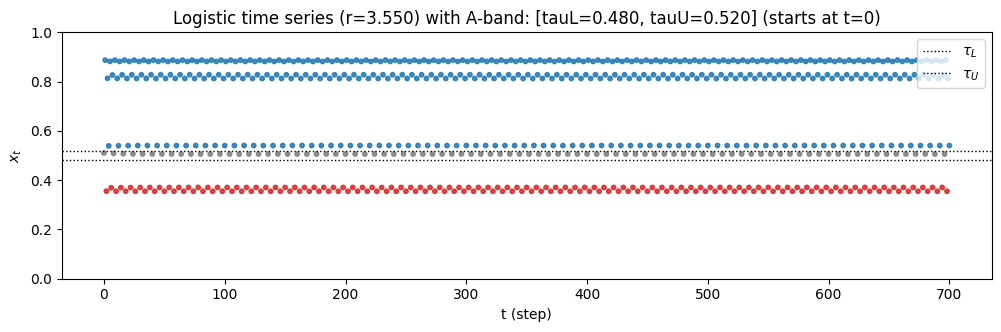

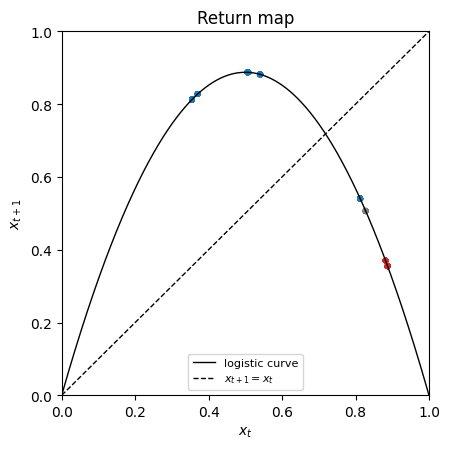

In [6]:

COLOR = {'A':'tab:gray','B':'tab:blue','D':'tab:red'}

def plot_time_series_band(xs: np.ndarray, syms: np.ndarray, tauL: float, tauU: float):
    colors = [COLOR[s] for s in syms]
    plt.figure(figsize=(12, 3.2))
    plt.scatter(np.arange(len(xs)), xs, s=10, c=colors, alpha=0.85)
    plt.axhline(tauL, color='k', linestyle=':', linewidth=1, label=r'$\tau_L$')
    plt.axhline(tauU, color='k', linestyle=':', linewidth=1, label=r'$\tau_U$')
    plt.ylim(0, 1)
    plt.xlabel('t (step)')
    plt.ylabel(r'$x_t$')
    plt.title(f'Logistic time series (r={r:.3f}) with A-band: [tauL={tauL:.3f}, tauU={tauU:.3f}] (starts at t=0)')
    plt.legend(loc='upper right')
    plt.show()

def plot_return_map(xs: np.ndarray, syms: np.ndarray, r: float, n_sample: int = 600):
    x_t   = xs[:-1]
    x_tp1 = xs[ 1:]
    c = [COLOR[s] for s in syms[1:]]  # color by symbol of x_{t+1}
    if len(x_t) > n_sample:
        idx = np.linspace(0, len(x_t)-1, n_sample).astype(int)
        x_t, x_tp1 = x_t[idx], x_tp1[idx]
        c = [c[i] for i in idx]
    plt.figure(figsize=(4.6, 4.6))
    plt.scatter(x_t, x_tp1, s=10, c=c, alpha=0.85)
    grid = np.linspace(0, 1, 500)
    plt.plot(grid, r*grid*(1-grid), 'k-', linewidth=1, label='logistic curve')
    plt.plot(grid, grid, 'k--', linewidth=1, label=r'$x_{t+1}=x_t$')
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel(r'$x_t$'); plt.ylabel(r'$x_{t+1}$')
    plt.title('Return map')
    plt.legend(loc='lower center', fontsize=8)
    plt.tight_layout()
    plt.show()

plot_time_series_band(xs, syms, tauL, tauU)
plot_return_map(xs, syms, r)



## 6. Transitions, Markov \(P\), Stationary \(\pi\), Spectral Gap, Entropy Rate


In [7]:

from collections import defaultdict
from typing import Dict, Tuple

def symbol_to_index_map(symbols=('A','B','D')) -> Dict[str,int]:
    return {s:i for i,s in enumerate(symbols)}

def transitions_count_and_matrix(syms: np.ndarray, symbols=('A','B','D'), eps_smooth=1e-12) -> Tuple[np.ndarray,np.ndarray]:
    s2i = symbol_to_index_map(symbols)
    K = len(symbols)
    C = np.zeros((K,K), dtype=float)
    for a,b in zip(syms[:-1], syms[1:]):
        C[s2i[a], s2i[b]] += 1.0
    row_sums = C.sum(axis=1, keepdims=True) + eps_smooth
    P = C / row_sums
    return C, P

def stationary_distribution(P: np.ndarray) -> np.ndarray:
    vals, vecs = np.linalg.eig(P.T)
    k = np.argmax(np.real(vals))
    v = np.real(vecs[:, k])
    v = np.maximum(v, 0.0)
    if v.sum() == 0:
        v = np.ones_like(v)
    return v / v.sum()

def spectral_gap(P: np.ndarray) -> float:
    vals = np.linalg.eigvals(P)
    vals = np.sort(np.abs(vals))[::-1]
    return float(max(0.0, 1.0 - (vals[1] if len(vals)>=2 else 1.0)))

def entropy_rate(P: np.ndarray, pi: np.ndarray, eps_smooth=1e-12) -> float:
    P2 = np.clip(P, eps_smooth, 1.0)
    H_rows = -(P2 * np.log2(P2)).sum(axis=1)
    return float(np.dot(pi, H_rows))

symbols_list = ('A','B','D')
C, P = transitions_count_and_matrix(syms, symbols=symbols_list)
pi = stationary_distribution(P)
gap = spectral_gap(P)
h_mu = entropy_rate(P, pi)

print("Transition counts C:\n", C)
print("Row-stochastic P (rounded):\n", np.round(P, 3))
print("Stationary distribution pi:", np.round(pi, 4))
print("Spectral gap:", round(gap, 6))
print("Entropy rate h_mu (bits/step):", round(h_mu, 6))


Transition counts C:
 [[  0.  88.   0.]
 [ 87. 175. 175.]
 [  0. 175.   0.]]
Row-stochastic P (rounded):
 [[0.    1.    0.   ]
 [0.199 0.4   0.4  ]
 [0.    1.    0.   ]]
Stationary distribution pi: [0.3333 0.3333 0.3333]
Spectral gap: 0.400458
Entropy rate h_mu (bits/step): 0.507003



## 7. Symbol Network Plot


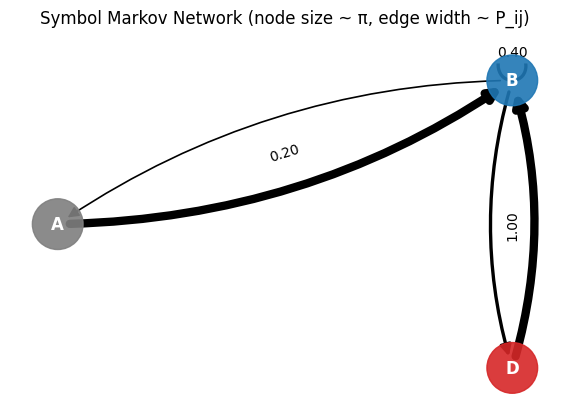

In [8]:

COLOR = {'A':'tab:gray','B':'tab:blue','D':'tab:red'}

def plot_symbol_network(P: np.ndarray, pi: np.ndarray, symbols=('A','B','D'), min_edge=0.02):
    G = nx.DiGraph()
    for s in symbols:
        G.add_node(s)
    for i, si in enumerate(symbols):
        for j, sj in enumerate(symbols):
            if P[i,j] >= min_edge:
                G.add_edge(si, sj, weight=float(P[i,j]))
    pos = {'A':(-0.5, 0.0), 'B':(0.5, 0.4), 'D':(0.5, -0.4)}
    node_sizes = [4000 * float(pi[symbols.index(s)]) for s in symbols]
    node_colors = [COLOR[s] for s in symbols]
    plt.figure(figsize=(5.8, 4.2))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='white')
    widths = [6.0 * d['weight'] for (_,_,d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=widths, arrows=True, arrowstyle='-|>', arrowsize=16, connectionstyle='arc3,rad=0.15')
    edge_labels = {(u,v): f"{P[symbols.index(u), symbols.index(v)]:.2f}" for (u,v) in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title('Symbol Markov Network (node size ~ π, edge width ~ P_ij)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_symbol_network(P, pi, symbols=symbols_list, min_edge=0.02)



## 8. Optional: Quick Parameter Sweep (No Transient)

We sweep `r`, simulate from \(x_0\) with no transient discard, symbolize from the first value, and record basic stats.


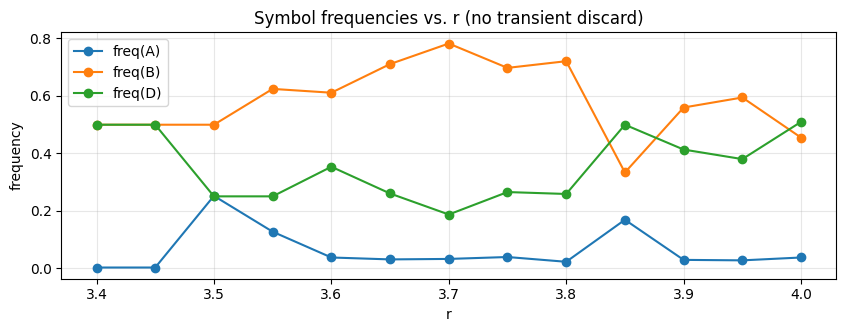

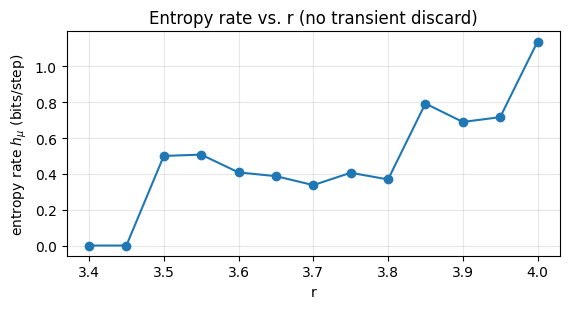

In [9]:

def sweep_r_values_no_transient(r_values, tauL: float, tauU: float,
                                x0: float = 0.12345, n_steps: int = 600):
    rows = []
    for rv in r_values:
        xs_ = simulate_logistic_no_transient(rv, x0, n_steps=n_steps)
        syms_ = classify_symbols_band(xs_, tauL=tauL, tauU=tauU)
        C_, P_ = transitions_count_and_matrix(syms_)
        pi_ = stationary_distribution(P_)
        h_ = entropy_rate(P_, pi_)
        u, c = np.unique(syms_, return_counts=True)
        freq = {s:0.0 for s in ('A','B','D')}
        for s, cnt in zip(u, c):
            freq[s] = cnt / len(syms_)
        rows.append((rv, freq['A'], freq['B'], freq['D'], h_))
    return np.array(rows)

r_list = np.linspace(3.4, 4.0, 13)
summary = sweep_r_values_no_transient(r_list, tauL=tauL, tauU=tauU, x0=x0, n_steps=600)

plt.figure(figsize=(10,3.2))
plt.plot(summary[:,0], summary[:,1], 'o-', label='freq(A)')
plt.plot(summary[:,0], summary[:,2], 'o-', label='freq(B)')
plt.plot(summary[:,0], summary[:,3], 'o-', label='freq(D)')
plt.xlabel('r'); plt.ylabel('frequency')
plt.title('Symbol frequencies vs. r (no transient discard)')
plt.legend(); plt.grid(alpha=0.3); plt.show()

plt.figure(figsize=(5.8,3.2))
plt.plot(summary[:,0], summary[:,4], 'o-')
plt.xlabel('r'); plt.ylabel(r'entropy rate $h_\mu$ (bits/step)')
plt.title('Entropy rate vs. r (no transient discard)')
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
